## Final Project Submission

Please fill out:
* Student name: Christopher Hollman
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@chollman91/formula-1-teammate-gaps-c20515dc432a


# Project Overview:
A King County real estate company is investing in physical advertising (mailings, billboards, etc) in order to attract new clients. This project aims to build a linear regression model of home sales to examine which zipcodes and attributes are associated with higher sales prices in order to maximize commissions generated by these ad campaigns. 

In [1]:
#importing neccessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing data
kc = pd.read_csv('data/kc_house_data.csv')
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Initial impressions and Data Selection:
This data set contains sales data for 21,597 houses from 2014 to 2015. Looking at individual columns, there are some obvious missing values for year renovated, view, and waterfront. We will address these later. There are also some columns that will be of limited use which we will drop from the dataset at this point. This data is being dropped either because it is redundant with other data or applies to the neighboring houses. Latitude and longitude data could be valuable for future analysis but will be ignored for now. I also created a column for house age at time of sale, meaning that year built and date sold can also be dropped. 

In [4]:
#dropping unwanted columns
kc.drop(['id', 
        'sqft_above', 
        'sqft_basement', 
        'lat', 
        'long', 
        'sqft_living15',
        'sqft_lot15'],
        axis = 1, inplace = True)

In [5]:
kc['sale_yr'] = kc['date'].str[-4:].astype(int) 
kc['sale_age'] = kc['sale_yr'] - kc['yr_built']
kc['sale_month'] = pd.to_datetime(kc['date']).dt.strftime("%b")
kc.drop(['yr_built', 'sale_yr', 'date'], axis=1, inplace=True)


### Examining Continuous Data Distributions:
At this stage I examined the sqft_living and price columns to look at distributions and presence of outliers. Both columns have pretty obvious outliers on the upper end which should be helped by applying some parameters to the dataset. For our purposes I applied an established method of the adding 1.5 times the IQR to the upper quartile and using that as the cutoff. Following this I performed log transformations to both columns in order to bring them into a more normal distribution and allow for later examination of coefficients. 

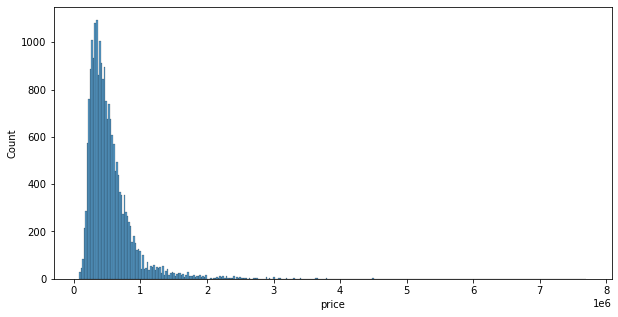

In [6]:
#plotting initial price data
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(kc['price']);
        

In [7]:
#calculating high and low cutoffs for outliers 
iqr=stats.iqr(kc['price'])
q75, q25 = np.percentile(kc['price'], [75 ,25])

low_limit = q25 - (1.5 * iqr)
high_limit = q75 + (1.5* iqr)
print("Lower Limit: ",low_limit)
print("Upper Limit: ",high_limit)

Lower Limit:  -162500.0
Upper Limit:  1129500.0


In [8]:
#dropping outliers from dataset
kc = kc[kc['price'] <= high_limit]
kc['price'].max()

1120000.0

In [9]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20439 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         20439 non-null  float64
 1   bedrooms      20439 non-null  int64  
 2   bathrooms     20439 non-null  float64
 3   sqft_living   20439 non-null  int64  
 4   sqft_lot      20439 non-null  int64  
 5   floors        20439 non-null  float64
 6   waterfront    18170 non-null  object 
 7   view          20381 non-null  object 
 8   condition     20439 non-null  object 
 9   grade         20439 non-null  object 
 10  yr_renovated  16812 non-null  float64
 11  zipcode       20439 non-null  int64  
 12  sale_age      20439 non-null  int64  
 13  sale_month    20439 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 2.3+ MB


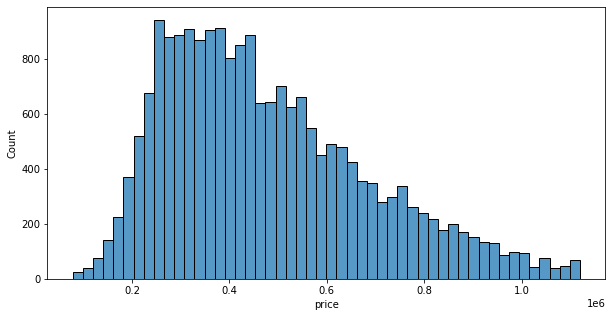

In [10]:
#plotting new price data
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(kc['price']);

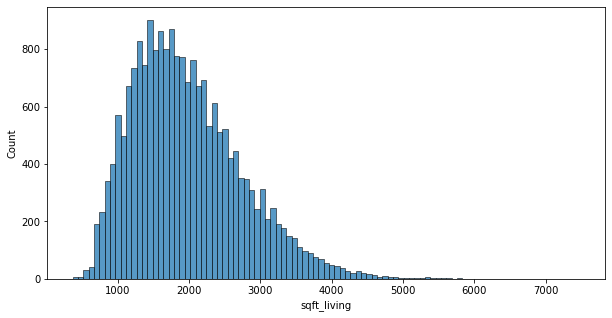

In [11]:
#plotting squre ft of living area
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(kc['sqft_living']);

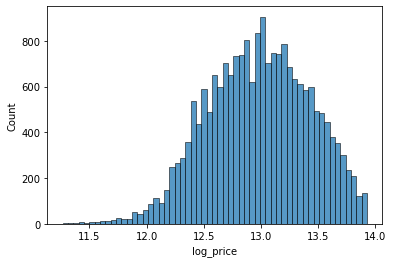

In [12]:
#performing log transformation on sale price data 
kc['log_price'] = np.log(kc['price'])
sns.histplot(kc['log_price']);


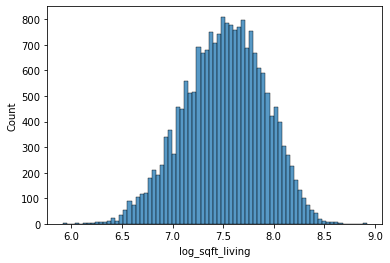

In [13]:
#repeating the proccess for square ft living area
kc['log_sqft_living'] = np.log(kc['sqft_living'])
sns.histplot(kc['log_sqft_living']);

### Initial Feature Selection and Baseline Model:
The next step is to examine a heatmap of numerical features that correlate with log price. Currently the features that correlate most closely (other than sale price) are sqft_living and bathrooms. We will use these two to build our baseline model.

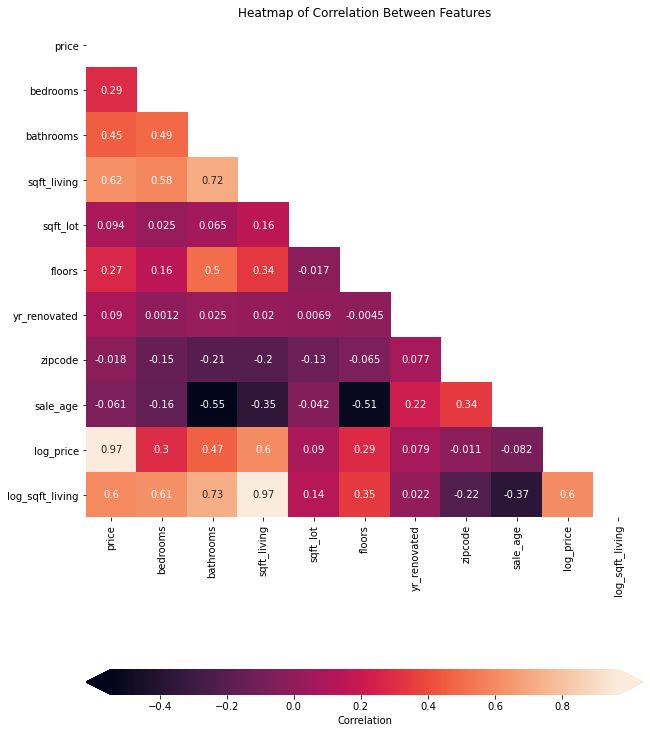

In [14]:
#creating correlation heatmap
corr = kc.corr()

fig, ax = plt.subplots(figsize=(10, 14))

sns.heatmap(
    data=corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
ax.set_title("Heatmap of Correlation Between Features");

In [15]:
#selecting inital features for baseline model
initial_features = ['bathrooms', 'log_sqft_living']

In [16]:
#creating baseline model
outcome = 'log_price'
predictors = kc[initial_features]
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=kc).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5907.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:26:35   Log-Likelihood:                -7801.4
No. Observations:               20439   AIC:                         1.561e+04
Df Residuals:                   20436   BIC:                         1.563e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.1234      0.062    131.756      0.000       8.003       8.244
bathrooms           0.0310      0.005      6.046      0.000       0.021       0.041
log_sqft_living     0.6379      0.009     69.577      0.000       0.620       0.656
==============================================================================
Omnibus:                      400.913   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.581
Skew:                          -0.112   Prob(JB):                     2.11e-53
Kurtosis:                       2.516   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
#validating model
kc_X=kc[initial_features]
kc_y=kc['log_price']
initial_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=7)
baseline_scores = cross_validate(
    estimator=initial_model,
    X=kc_X,
    y=kc_y,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.36876959554635746
Validation score: 0.3625666905459722


### Baseline Model Interpretation:
Current r-squared is .36 for both our training and test sets. This is a poor score but fine for a baseline model. The next step to improving this model is to add in more features, which will require some scrubbing of our other data. We will start by investigating missing and null values.

In [18]:
kc.isnull().sum()

price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
floors                0
waterfront         2269
view                 58
condition             0
grade                 0
yr_renovated       3627
zipcode               0
sale_age              0
sale_month            0
log_price             0
log_sqft_living       0
dtype: int64

### Scrubbing Data:
As we can see here there are null values present in 3 columns. We also recall from the initial data exploration that we will need to convert some of the string values into integers in order for them to function in our model. We will be altering yr_renovated, waterfront, view, condition, and grade before adding them into our next model along with some features that don't need any work, such as floors, bedrooms, sale age, lot size.

In [19]:
#replacing na values with 0, and converting yes values to 1 and no values to 0
kc['waterfront'] = kc['waterfront'].fillna(0).replace('NO', 0).replace('YES', 1)
kc['waterfront'].value_counts()

0    20388
1       51
Name: waterfront, dtype: int64

In [20]:
#label encoding for view column
kc['view'] = kc['view'].fillna(1).replace(
    'NONE', 1).replace(
    'FAIR', 2).replace(
    'AVERAGE', 3).replace(
    'GOOD', 4).replace(
    'EXCELLENT', 5)
kc['view'].value_counts()

1    18868
3      804
4      347
2      274
5      146
Name: view, dtype: int64

In [21]:
#repeating process for condition column
kc['condition'].value_counts()

Average      13268
Good          5415
Very Good     1560
Fair           168
Poor            28
Name: condition, dtype: int64

In [22]:
kc['condition'] = kc['condition'].replace(
    'Poor', 1).replace(
    'Fair', 2).replace(
    'Average', 3).replace(
    'Good', 4).replace(
    'Very Good', 5)

In [23]:
#converting grade scores to numerical values and converting to 1-10 scale rather than 3-12
kc['grade'] = kc['grade'].str[:2].astype(int)-2
kc['grade'].value_counts()

5     8962
6     5943
7     2319
4     2037
8      766
3      242
9      137
2       27
10       5
1        1
Name: grade, dtype: int64

In [24]:
#creating a yes/no column for whether or not a house has been renovated. 
kc['yr_renovated'].isnull().sum()

3627

In [25]:
kc['yr_renovated'] = kc['yr_renovated'].fillna(0)
kc['yr_renovated'].value_counts()

0.0       19814
2014.0       66
2013.0       29
2000.0       26
2007.0       24
          ...  
1934.0        1
1950.0        1
1953.0        1
1948.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [26]:
#any house that has been renovated, regardless of year gets a 1, all others get a 0
kc['yr_renovated'].values[kc['yr_renovated'] > 1] = 1

In [27]:
kc['yr_renovated'].value_counts()

0.0    19814
1.0      625
Name: yr_renovated, dtype: int64

In [28]:
kc.rename(columns={'yr_renovated':'is_renovated'}, inplace=True)

### Zipcode and Sale Month Data:
We will also create dummy variables for sales month and zipcodes. We examine the average sales price associated with these features and will ultimately drop the column closest to the average without losing significant data in order to eliminate multicollinearity and provide a sound reference column. We will end up settling on the month of August and the zipcode 98070, which is associated with Vashon Island. This is a good reference point for our dataset as it doesn't represent either extreme in terms of price. We chose this over 98034 (Kirkland) because we could salvage an additional 411 data points while only straying an additional $158 from the price mean of the dataset.

In [29]:
kc['price'].mean()

476702.6321248593

In [30]:
#calculating absolute value of zipcode price mean minus mean of the whole dataset
zip_means = kc.groupby('zipcode').mean()
zip_means.sort_values('price')
zip_means['zip_minus_pop'] = np.abs(zip_means['price'] - kc['price'].mean())
zip_means.sort_values('zip_minus_pop')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,is_renovated,sale_age,log_price,log_sqft_living,zip_minus_pop
zipcode,,,,,,,,,,,,,,,
98034,474312.372624,3.467681,2.085076,1913.684411,8928.220532,1.297529,0.000000,1.117871,3.380228,5.412548,0.005703,38.387833,13.029482,7.499655,2390.259501
98070,474153.878261,2.773913,1.893478,1869.121739,97048.191304,1.417391,0.156522,2.060870,3.686957,5.252174,0.052174,46.469565,13.008124,7.452835,2548.753864
98024,486844.794521,3.232877,2.010274,2097.465753,84140.657534,1.356164,0.000000,1.150685,3.273973,5.315068,0.054795,45.931507,13.014618,7.543849,10142.162396
98059,465147.444690,3.699115,2.299226,2324.579646,14470.214602,1.618363,0.000000,1.039823,3.407080,5.783186,0.017699,25.882743,12.987605,7.690852,11555.187435
98011,490377.107692,3.548718,2.278205,2253.097436,11314.138462,1.502564,0.000000,1.061538,3.220513,5.774359,0.020513,32.123077,13.074285,7.670594,13674.475567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98075,730011.390909,3.839394,2.669697,2921.778788,17571.321212,1.796970,0.000000,1.190909,3.212121,6.918182,0.012121,20.690909,13.480651,7.945468,253308.758784
98005,744201.769737,3.809211,2.345395,2510.197368,17707.532895,1.236842,0.000000,1.078947,3.730263,6.263158,0.019737,46.105263,13.497228,7.781730,267499.137612
98004,836026.655844,3.428571,1.933442,1991.038961,10783.727273,1.269481,0.000000,1.038961,3.629870,5.649351,0.051948,52.714286,13.621263,7.547439,359324.023719


In [31]:
#verifying counts
kc.loc[kc['zipcode'] == 98034, 'zipcode'].count()

526

In [32]:
kc.loc[kc['zipcode'] == 98070, 'zipcode'].count()

115

In [33]:
month_means = kc.groupby('sale_month').mean()
month_means.sort_values('price')
month_means['month_minus_pop'] = np.abs(month_means['price'] - kc['price'].mean())
month_means.sort_values('month_minus_pop')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,is_renovated,zipcode,sale_age,log_price,log_sqft_living,month_minus_pop
sale_month,,,,,,,,,,,,,,,,
Aug,476605.881365,3.314735,2.060672,1984.683099,14158.032503,1.479686,0.001083,1.159263,3.442037,5.561213,0.029794,98077.685807,42.439870,12.981146,7.520816,96.750760
Mar,478307.780543,3.320136,2.000283,1924.037330,14473.521493,1.447398,0.001131,1.164027,3.349548,5.459276,0.033371,98078.312217,44.443439,12.977699,7.486525,1605.148418
Sep,474069.905493,3.328411,2.081512,1987.284702,15363.774365,1.474306,0.002363,1.191376,3.426462,5.533373,0.038393,98078.438866,43.363851,12.977678,7.519150,2632.726632
May,480985.615215,3.308707,2.043536,1969.641161,16423.009235,1.467018,0.002199,1.174582,3.415567,5.532982,0.036939,98079.899296,44.170624,12.990071,7.506919,4282.983091
Oct,471169.249859,3.318259,2.050170,1976.977388,15089.928208,1.483324,0.003392,1.178067,3.409836,5.506501,0.032787,98079.429056,44.392877,12.965213,7.509993,5533.382266
Jul,483202.379310,3.354885,2.083693,2020.439176,13451.458812,1.503592,0.002874,1.161877,3.440134,5.589080,0.033046,98075.179119,42.302682,12.990184,7.534433,6499.747185
Jun,489878.043372,3.376218,2.099781,2020.577973,13913.659844,1.492690,0.003411,1.168616,3.454678,5.610624,0.026803,98080.361598,43.170565,13.006495,7.535937,13175.411247
Dec,462401.906676,3.348887,2.040739,1988.895190,15347.331658,1.469131,0.002872,1.166547,3.391242,5.540560,0.024408,98077.900215,42.632448,12.948620,7.519883,14300.725449
Nov,462244.289768,3.302465,2.017924,1943.764003,14331.373413,1.480956,0.003734,1.164302,3.398058,5.495892,0.031367,98079.081404,44.174757,12.945373,7.493572,14458.342356


In [34]:
kc.loc[kc['sale_month'] == 'Aug', 'sale_month'].count()

1846

In [35]:
kc.loc[kc['sale_month'] == 'Mar', 'sale_month'].count()

1768

### Second Model:
At this stage we select features for our second model. For now we are going to continue to ignore zipcode until our next version. We will however add in some of the label encoded categorical features mentioned above.

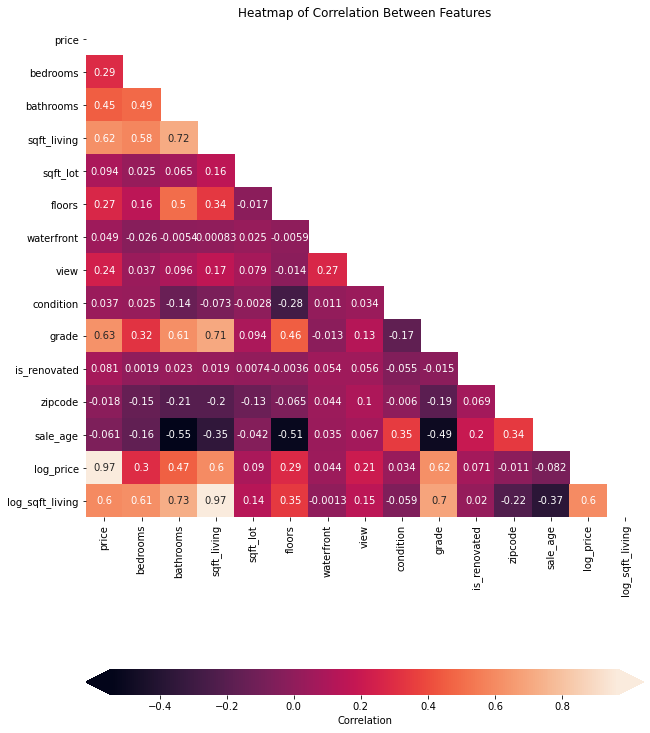

In [36]:
#Second heatmap
corr = kc.corr()

fig, ax = plt.subplots(figsize=(10, 14))

sns.heatmap(
    data=corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})
ax.set_title("Heatmap of Correlation Between Features");

In [37]:
#Building Second Model
second_feature_set = ['bedrooms', 'bathrooms', 'sqft_living', 
                      'sqft_lot', 'floors', 'waterfront', 'view', 
                      'condition', 'grade', 'is_renovated', 'sale_age']
outcome = 'log_price'
predictors = kc[second_feature_set]
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=kc).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     2136.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:26:36   Log-Likelihood:                -4639.3
No. Observations:               20439   AIC:                             9303.
Df Residuals:                   20427   BIC:                             9398.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.8567      0.022    502.903      0.000      10.814      10.899
bedrooms        -0.0231      0.003     -7.684      0.000      -0.029      -0.017
bathrooms        0.0809      0.005     15.880      0.000       0.071       0.091
sqft_living      0.0002   5.13e-06     30.821      0.000       0.000       0.000
sqft_lot      4.953e-08   5.43e-08      0.912      0.362   -5.69e-08    1.56e-07
floors           0.0913      0.005     18.210      0.000       0.081       0.101
waterfront       0.1755      0.044      3.953      0.000       0.088       0.262
view             0.0450      0.004     12.619      0.000       0.038       0.052
condition        0.0418      0.004     11.615      0.000       0.035       0.049
grade            0.2093      0.003     65.027      0.000       0.203       0.216
is_renovated     0.0017      0.013      0.132      0.895      -0.024       0.027
sale_age         0.0053      0.000     51.339      0.000       0.005       0.006
==============================================================================
Omnibus:                      175.298   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.312
Skew:                          -0.218   Prob(JB):                     4.25e-40
Kurtosis:                       3.153   Cond. No.                     8.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
#verifying 
second_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=7)

baseline_scores = cross_validate(
    estimator=second_model,
    X=kc[second_feature_set],
    y=kc['log_price'],
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.5345182403241777
Validation score: 0.5349575522086358


### Second Model Interpretation:
As expected, these features have improved our r-squared. Our model is performing equally on both training and test sets. The next step is to add in zipcode and sales month data. We will do this with dummy variables, dropping Vashon Island and Aug as determined earlier. 

In [39]:
#Creating month dummies and adding to new dataframe
month_dummies = pd.get_dummies(kc['sale_month'], prefix='sale_month', drop_first=False)
kc_preprocessed = kc.drop(['sale_month'], axis=1)
kc_preprocessed = pd.concat([kc_preprocessed, month_dummies], axis=1)
kc_preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode',
       'sale_age', 'log_price', 'log_sqft_living', 'sale_month_Apr',
       'sale_month_Aug', 'sale_month_Dec', 'sale_month_Feb', 'sale_month_Jan',
       'sale_month_Jul', 'sale_month_Jun', 'sale_month_Mar', 'sale_month_May',
       'sale_month_Nov', 'sale_month_Oct', 'sale_month_Sep'],
      dtype='object')

In [40]:
#repeating proccess for zipcode 
zip_dummies = pd.get_dummies(kc['zipcode'], prefix='zipcode', drop_first=False)
kc_preprocessed.drop('zipcode', axis=1, inplace=True)
kc_preprocessed = pd.concat([kc_preprocessed, zip_dummies], axis=1)
kc_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,0,1,3,5,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,1,3,5,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,1,3,4,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1,5,5,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,1,3,6,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#preserving original price data for a later visualization 
kc_viz = kc_preprocessed.copy()
kc_preprocessed.drop(['price', 'sqft_living'], axis=1, inplace=True)

In [42]:
#dropping reference columns
kc_preprocessed.drop(['sale_month_Aug', 'zipcode_98070'], axis=1, inplace=True)


In [43]:
#building next model
outcome = 'log_price'
predictors = kc_preprocessed.drop(['log_price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=kc_preprocessed).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1172.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:26:36   Log-Likelihood:                 6250.6
No. Observations:               20439   AIC:                        -1.232e+04
Df Residuals:                   20347   BIC:                        -1.159e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5987      0.042    206.619      0.000       8.517       8.680
bedrooms           -0.0122      0.002     -6.664      0.000      -0.016      -0.009
bathrooms           0.0202      0.003      6.589      0.000       0.014       0.026
sqft_lot         7.427e-07   3.42e-08     21.702      0.000    6.76e-07     8.1e-07
floors             -0.0007      0.003     -0.209      0.835      -0.007       0.006
waterfront          0.3591      0.027     13.360      0.000       0.306       0.412
view                0.0580      0.002     26.813      0.000       0.054       0.062
condition           0.0441      0.002     20.098      0.000       0.040       0.048
grade               0.1065      0.002     53.049      0.000       0.103       0.110
is_renovated        0.0497      0.008      6.494      0.000       0.035       0.065
sale_age            0.0008   7.37e-05     11.406      0.000       0.001       0.001
log_sqft_living     0.4545      0.006     72.633      0.000       0.442       0.467
sale_month_Apr      0.0683      0.006     11.957      0.000       0.057       0.080
sale_month_Dec     -0.0044      0.006     -0.696      0.486      -0.017       0.008
sale_month_Feb      0.0203      0.007      3.044      0.002       0.007       0.033
sale_month_Jan     -0.0033      0.007     -0.455      0.649      -0.017       0.011
sale_month_Jul     -0.0020      0.006     -0.357      0.721      -0.013       0.009
sale_month_Jun      0.0061      0.006      1.067      0.286      -0.005       0.017
sale_month_Mar      0.0450      0.006      7.543      0.000       0.033       0.057
sale_month_May      0.0104      0.006      1.851      0.064      -0.001       0.021
sale_month_Nov     -0.0117      0.006     -1.819      0.069      -0.024       0.001
sale_month_Oct     -0.0082      0.006     -1.377      0.169      -0.020       0.003
sale_month_Sep     -0.0050      0.006     -0.822      0.411      -0.017       0.007
zipcode_98001      -0.3357      0.020    -16.940      0.000      -0.374      -0.297
zipcode_98002      -0.3748      0.022    -17.364      0.000      -0.417      -0.332
zipcode_98003      -0.3289      0.020    -16.062      0.000      -0.369      -0.289
zipcode_98004       0.7104      0.023     31.330      0.000       0.666       0.755
zipcode_98005       0.4062      0.023     17.826      0.000       0.362       0.451
zipcode_98006       0.3024      0.020     15.375      0.000       0.264       0.341
zipcode_98007       0.3046      0.023     13.094      0.000       0.259       0.350
zipcode_98008       0.2927      0.021     14.169      0.000       0.252       0.333
zipcode_98010      -0.0699      0.025     -2.813      0.005      -0.119      -0.021
zipcode_98011       0.1247      0.022      5.753      0.000       0.082       0.167
zipcode_98014      -0.0261      0.024     -1.103      0.270

In [44]:
#validating
X_preprocessed = kc_preprocessed.drop(['log_price'],axis=1)
y_preprocessed = kc_preprocessed['log_price']
third_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=7)

baseline_scores = cross_validate(
    estimator=third_model,
    X=X_preprocessed,
    y=y_preprocessed,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8398291519271561
Validation score: 0.838250024641934


### Third Model Interpretation:
There is a great increase in R squared with the addition of zipcodes. We do have some high p values, including the majority of the sales month data that will need to be removed, as it suggests a lack of correlation with sales price. 

In [45]:
#dropping features with high p values
kc_final = kc_preprocessed.drop(['floors',
                                 'sale_month_Dec',
                                 'sale_month_Jan',
                                 'sale_month_Jul',
                                 'sale_month_Jun',
                                 'sale_month_May',
                                 'sale_month_Nov',
                                 'sale_month_Oct',
                                 'sale_month_Sep',
                                 'zipcode_98014',
                                 'zipcode_98019',
                                 'zipcode_98045',
                                 'zipcode_98056',
                                 'zipcode_98059',
                                 'zipcode_98106',
                                 'zipcode_98108',
                                 'zipcode_98166'],axis=1)                

In [46]:
outcome = 'log_price'
predictors = kc_final.drop(['log_price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=kc_final).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1438.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:26:38   Log-Likelihood:                 6222.1
No. Observations:               20439   AIC:                        -1.229e+04
Df Residuals:                   20364   BIC:                        -1.170e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5694      0.037    229.850      0.000       8.496       8.642
bedrooms           -0.0122      0.002     -6.654      0.000      -0.016      -0.009
bathrooms           0.0194      0.003      6.432      0.000       0.013       0.025
sqft_lot         7.533e-07   3.33e-08     22.639      0.000    6.88e-07    8.19e-07
waterfront          0.3604      0.026     13.710      0.000       0.309       0.412
view                0.0574      0.002     26.661      0.000       0.053       0.062
condition           0.0447      0.002     20.609      0.000       0.040       0.049
grade               0.1064      0.002     53.467      0.000       0.103       0.110
is_renovated        0.0501      0.008      6.549      0.000       0.035       0.065
sale_age            0.0008    6.9e-05     11.597      0.000       0.001       0.001
log_sqft_living     0.4568      0.006     73.347      0.000       0.445       0.469
sale_month_Apr      0.0691      0.004     16.574      0.000       0.061       0.077
sale_month_Feb      0.0214      0.005      3.966      0.000       0.011       0.032
sale_month_Mar      0.0460      0.005     10.223      0.000       0.037       0.055
zipcode_98001      -0.3244      0.010    -31.956      0.000      -0.344      -0.304
zipcode_98002      -0.3631      0.013    -27.347      0.000      -0.389      -0.337
zipcode_98003      -0.3175      0.011    -27.980      0.000      -0.340      -0.295
zipcode_98004       0.7227      0.015     48.329      0.000       0.693       0.752
zipcode_98005       0.4171      0.015     27.620      0.000       0.388       0.447
zipcode_98006       0.3134      0.010     31.886      0.000       0.294       0.333
zipcode_98007       0.3165      0.016     20.031      0.000       0.286       0.347
zipcode_98008       0.3041      0.012     26.100      0.000       0.281       0.327
zipcode_98010      -0.0595      0.018     -3.248      0.001      -0.095      -0.024
zipcode_98011       0.1351      0.013     10.099      0.000       0.109       0.161
zipcode_98022      -0.2805      0.012    -22.480      0.000      -0.305      -0.256
zipcode_98023      -0.3571      0.009    -40.199      0.000      -0.375      -0.340
zipcode_98024       0.1037      0.021      4.853      0.000       0.062       0.146
zipcode_98027       0.1900      0.010     19.344      0.000       0.171       0.209
zipcode_98028       0.0884      0.011      7.805      0.000       0.066       0.111
zipcode_98029       0.2730      0.011     25.008      0.000       0.252       0.294
zipcode_98030      -0.2751      0.012    -23.285      0.000      -0.298      -0.252
zipcode_98031      -0.2535      0.011    -22.083      0.000      -0.276      -0.231
zipcode_98032      -0.3678      0.016    -22.342      0.000      -0.400      -0.335
zipcode_98033       0.4294      0.010     42.500      0.000

In [47]:
X_final = kc_final.drop(['log_price'],axis=1)
y_final = kc_final['log_price']
final_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=7)

baseline_scores = cross_validate(
    estimator=final_model,
    X=X_final,
    y=y_final,
    return_train_score=True,
    cv=splitter)


print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.839328094137288
Validation score: 0.8382194790105693


### Investigating Assumptions:
Looking below we see that the data is in fact linear, and appears to be within reason in terms of homoscedasticity. We do see while looking at normality that there are still some outliers giving our model some issues that will eventually need to be dealt with. In terms of multicollinearity, we will use a cutoff of .7 meaning we need to drop either sqft_living or bathrooms. I have elected to drop bathrooms. 

In [48]:
#splitting data for investigating assumptions
X_train, X_test, y_train, y_test = train_test_split(X_final, 
                                                    y_final, 
                                                    test_size=0.33, 
                                                    random_state=7)

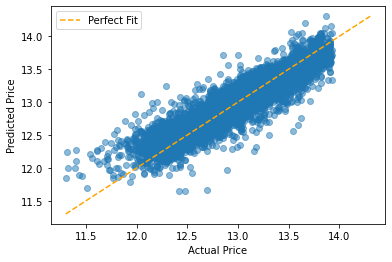

In [49]:

preds=model.predict(X_test)
fig, ax = plt.subplots()
perfect_line = np.arange(y_test.min(), 15)
ax.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

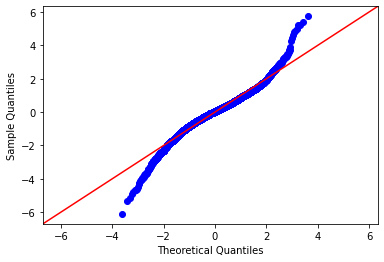

In [50]:
#graphing residuals, note the effect of outliers
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [51]:
#function do identrift multicollinear features
def multicolinearity(data):
    pred = data.drop('log_price', axis =1)
    df = pred.corr().abs().stack().reset_index().sort_values(0,ascending=False)
    
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace=True)
    df.drop(columns=['level_0', 'level_1'], inplace=True)
    df.columns = ['cc']
    df.drop_duplicates(inplace=True)
    return df[(df.cc > .7) & (df.cc < 1)]

In [52]:
multicolinearity(kc_final)

,cc
pairs,
"(bathrooms, log_sqft_living)",0.731482


In [53]:
#dropping bathrooms
kc_final.drop('bathrooms',axis=1, inplace=True)

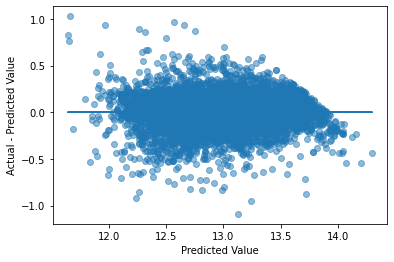

In [54]:
#graphing residuals to check for heteroscedasticity
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Final Model interpretation:
This is where we will stop developing our model. We have no high p_values and have gotten to a place where we can start to interpret coefficients. Our final r squared is .839, which is an acceptable score for our purposes. The limits of our model as a predictor are apparent by calculating mean squared error of .179, which means that on average our price model is off by almost 18 percent. At this point we will check to make sure our model meets the required assumptions and then examine zipcodes with high coefficients and assess their viability from a marketing standpoint.

In [55]:
outcome = 'log_price'
predictors = kc_final.drop(['log_price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=kc_final).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1454.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:26:39   Log-Likelihood:                 6201.4
No. Observations:               20439   AIC:                        -1.225e+04
Df Residuals:                   20365   BIC:                        -1.167e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.4717      0.034    248.560      0.000       8.405       8.538
bedrooms           -0.0104      0.002     -5.712      0.000      -0.014      -0.007
sqft_lot         7.507e-07   3.33e-08     22.539      0.000    6.85e-07    8.16e-07
waterfront          0.3618      0.026     13.750      0.000       0.310       0.413
view                0.0580      0.002     26.890      0.000       0.054       0.062
condition           0.0455      0.002     20.995      0.000       0.041       0.050
grade               0.1070      0.002     53.735      0.000       0.103       0.111
is_renovated        0.0567      0.008      7.478      0.000       0.042       0.072
sale_age            0.0006   6.25e-05      9.780      0.000       0.000       0.001
log_sqft_living     0.4744      0.006     84.727      0.000       0.463       0.485
sale_month_Apr      0.0692      0.004     16.567      0.000       0.061       0.077
sale_month_Feb      0.0213      0.005      3.957      0.000       0.011       0.032
sale_month_Mar      0.0458      0.005     10.159      0.000       0.037       0.055
zipcode_98001      -0.3257      0.010    -32.067      0.000      -0.346      -0.306
zipcode_98002      -0.3626      0.013    -27.280      0.000      -0.389      -0.337
zipcode_98003      -0.3177      0.011    -27.971      0.000      -0.340      -0.295
zipcode_98004       0.7218      0.015     48.222      0.000       0.692       0.751
zipcode_98005       0.4179      0.015     27.647      0.000       0.388       0.448
zipcode_98006       0.3128      0.010     31.794      0.000       0.293       0.332
zipcode_98007       0.3161      0.016     19.983      0.000       0.285       0.347
zipcode_98008       0.3039      0.012     26.051      0.000       0.281       0.327
zipcode_98010      -0.0620      0.018     -3.381      0.001      -0.098      -0.026
zipcode_98011       0.1351      0.013     10.085      0.000       0.109       0.161
zipcode_98022      -0.2812      0.012    -22.519      0.000      -0.306      -0.257
zipcode_98023      -0.3581      0.009    -40.269      0.000      -0.375      -0.341
zipcode_98024       0.1040      0.021      4.863      0.000       0.062       0.146
zipcode_98027       0.1910      0.010     19.431      0.000       0.172       0.210
zipcode_98028       0.0879      0.011      7.752      0.000       0.066       0.110
zipcode_98029       0.2756      0.011     25.242      0.000       0.254       0.297
zipcode_98030      -0.2753      0.012    -23.273      0.000      -0.298      -0.252
zipcode_98031      -0.2530      0.011    -22.018      0.000      -0.276      -0.231
zipcode_98032      -0.3705      0.016    -22.490      0.000      -0.403      -0.338
zipcode_98033       0.4293      0.010     42.453      0.000       0.410       0.449
zipcode_98034       0.1968      0.009     22.644      0.000

In [56]:
X_final = kc_final.drop(['log_price'],axis=1)
y_final = kc_final['log_price']
final_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=7)

baseline_scores = cross_validate(
    estimator=final_model,
    X=X_final,
    y=y_final,
    return_train_score=True,
    cv=splitter)


print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8389785500676824
Validation score: 0.8379562920833503


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_final, 
                                                    y_final, 
                                                    test_size=0.33, 
                                                    random_state=7)

#calculating MSE
final_model.fit(X_train, y_train)
mean_squared_error(y_test, final_model.predict(X_test), squared=False)


0.17978557378635796

In [58]:
#Viewing counts for sales in top 5 high coefficient zipcodes 
print(kc.loc[kc['zipcode'] == 98039, 'zipcode'].count())
print(kc.loc[kc['zipcode'] == 98004, 'zipcode'].count())
print(kc.loc[kc['zipcode'] == 98112, 'zipcode'].count())
print(kc.loc[kc['zipcode'] == 98102, 'zipcode'].count())
print(kc.loc[kc['zipcode'] == 98109, 'zipcode'].count())


6
154
167
88
86


### Zipcode Selection:
The zipcodes above are in order of highest coefficients related to log price. As 98039 (Medina)only had 6 total sales in a two year span, it won't be viable to advertise there. This being an extremely high end waterfront area on the shore of the Puget Sound, it is probable that some of our high outliers may have come from this zipcode. We are left with 98004(Bellevue), 98112(Washington/Madison Park, Montlake, and Arboretum) and 98102(Capitol Hill) The coefficients are as follows:
* 98004: .723
* 98112: .569
* 98102: .552 
In addition, waterfront properties carry a coefficient of 0.361. This should be taken into account when choosing locations for larger ads.

In [59]:
#separating top zipcodes for plotting
top_zips = kc_viz.loc[(kc_viz['zipcode_98004']==1)|(
    kc_viz['zipcode_98112']==1)|(
    kc_viz['zipcode_98102']==1)]
    
top_zips

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
27,667000.0,3,1.00,1400,1581,1.5,0,1,5,6,...,0,0,0,0,0,0,0,0,0,0
66,975000.0,4,2.50,2720,11049,2.0,0,1,3,8,...,0,0,0,0,0,0,0,0,0,0
100,850830.0,3,2.50,2070,13241,1.5,0,1,5,7,...,0,0,0,0,0,0,0,0,0,0
103,1090000.0,3,2.50,2920,8113,2.0,0,1,3,6,...,0,0,0,0,0,0,0,0,0,0
260,780000.0,3,1.00,1660,4400,1.5,0,1,3,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21259,950000.0,2,2.25,2200,2043,2.0,0,1,3,7,...,0,0,0,0,0,0,0,0,0,0
21288,799950.0,3,2.25,1860,1386,3.0,0,1,3,7,...,0,0,0,0,0,0,0,0,0,0
21517,999999.0,3,2.50,2100,4097,2.0,0,1,3,7,...,0,0,0,0,0,0,0,0,0,0
21536,516500.0,1,1.25,1100,638,3.0,0,1,3,7,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#repeating process for rest of zipcodes
bottom_zips = kc_viz.loc[(kc_viz['zipcode_98004']==0)|(
    kc_viz['zipcode_98112']==0)|(
    kc_viz['zipcode_98102']==0)]

In [61]:
#Altering Prices to plot as millions of USD
bottom_zips['price'] = bottom_zips['price']/1000000
top_zips['price'] = top_zips['price']/1000000

In [62]:
#generating line of best fit
x = np.array(kc['sqft_living'])
y = np.array(kc['price']/1000000)
m,b = np.polyfit(x,y,1)

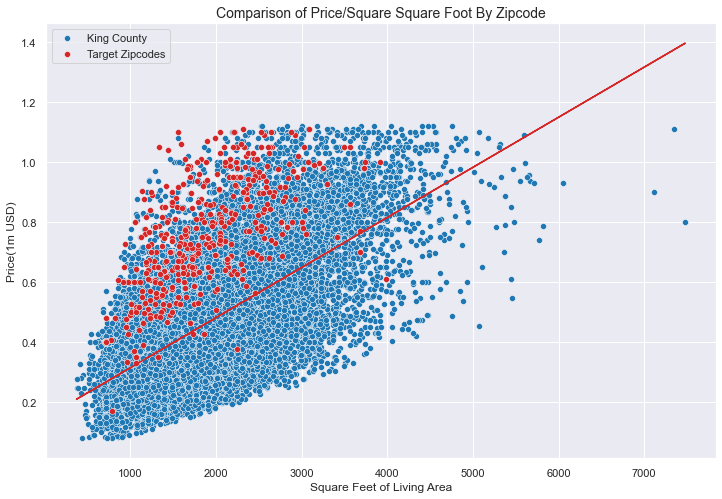

In [63]:
#Plotting zipcode sales data for deliverables
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=bottom_zips['sqft_living'],
                y=bottom_zips['price'], 
                color='Tab:Blue',
                label='King County')
sns.scatterplot(x=top_zips['sqft_living'],
                y=top_zips['price'],
                color='Tab:Red',
                label='Target Zipcodes')
plt.plot(x, m*x + b, 
         color = 'Tab:Red') 
         
ax.set_title("Comparison of Price/Square Square Foot By Zipcode",fontsize=14)
ax.set_ylabel("Price(1m USD)",fontsize=12)
ax.set_xlabel('Square Feet of Living Area',fontsize=12);

### Conclusions and Next Steps 
According to our model, it would be best to target physical advertising in the area codes of 98004, 98112, and 98102. As all of these neighborhoods do contain waterfront areas, it would be prudent to focus advertising particularly in waterfront areas within those zipcodes. The next steps I would suggest for this project would be:
* Reintroduce lattitude and longitude data to plot sales within King County. This could identify more specific regions or areas that tend to have higher sales prices that aren't necessarily reflected in the zip code data.
* Continue to look into and reduce the effect of outliers on the model.